# Kernel Comparison for Approximate Gaussian Process Classification
The kernel functions of the Radial Basis Function (RBF) and the Laplacian<br>
$$ k_{\text{RBF}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( -\frac{1}{2} (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-2} (\mathbf{x_1} - \mathbf{x_2}) \right) $$
$$ k_{\text{Laplacian}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( - \left(\mathbf{x_1} - \mathbf{x_2}\right)^\top \Theta^{-1} \left(\mathbf{x_1} - \mathbf{x_2}\right) \right) $$
are fairly similar. However, the Laplacian kernel transform data differently than the RBF kernel and can be better suited for curve-shaped data, see e.g. [Bauckhage et al.](https://ieeexplore.ieee.org/document/9260042).<br>
In this notebook, the RBF and Laplacian kernel are compared on their suitability in classification task using an Approximate Gaussian Process.

## Data
The data we will be looking at in this demonstration are two half-moon-shaped clusters of two-dimensional datapoints.

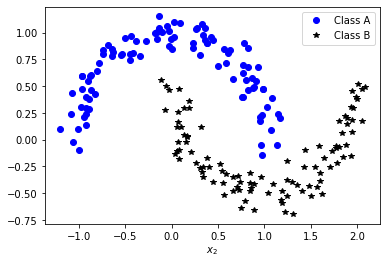

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=200, shuffle=False, noise=0.1)

plt.figure()
plt.plot(x[y == 0, 0], x[y == 0, 1], 'o', color='blue')
plt.plot(x[y == 1, 0], x[y == 1, 1], '*', color='black')
plt.legend(["Class A", "Class B"])
plt.xlabel(r'$x_1$')
plt.xlabel(r'$x_2$')
plt.show()

## Classifier
An Approximate Gaussian Process will be used as a classifier to identify members of class A (blue circles) in the above plot.

In [6]:
import gpytorch
import torch
from gpytorch.likelihoods import likelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy

In [7]:
# Setting up the classification model
class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x, base_kernel):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

Randomly splitting the dataset into a training- and validation subset.

In [8]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

torch.random.manual_seed(0)
rands = torch.rand(len(y))
train_x = x[rands <= 0.8]
train_y = y[rands <= 0.8]
test_x = x[rands > 0.8]
test_y = y[rands > 0.8]


# Initialize likelihoods by using the RBF and the Laplacian Kernel
base_kernels = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.LaplacianKernel()]
likelihoods = [gpytorch.likelihoods.BernoulliLikelihood() for _ in base_kernels]

# Initialize models by using the RBF and the Laplacian Kernel
models = [GPClassificationModel(train_x, base_kernel) for base_kernel in base_kernels]

Train the classifier using the `RBFKernel`:

In [9]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50
assert training_iterations > 2, "Why smoke_test?"  # TODO: Remove

# Model 1
rbf_model = models[0]
rbf_likelihood = likelihoods[0]

# Find optimal model hyperparameters
rbf_model.train()
rbf_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(rbf_model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(rbf_likelihood, rbf_model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = rbf_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.909
Iter 2/50 - Loss: 43.355
Iter 3/50 - Loss: 101.690
Iter 4/50 - Loss: 34.954
Iter 5/50 - Loss: 53.538
Iter 6/50 - Loss: 54.186
Iter 7/50 - Loss: 28.762
Iter 8/50 - Loss: 17.917
Iter 9/50 - Loss: 22.284
Iter 10/50 - Loss: 22.294
Iter 11/50 - Loss: 15.335
Iter 12/50 - Loss: 9.789
Iter 13/50 - Loss: 9.074
Iter 14/50 - Loss: 9.751
Iter 15/50 - Loss: 8.780
Iter 16/50 - Loss: 6.737
Iter 17/50 - Loss: 5.185
Iter 18/50 - Loss: 4.615
Iter 19/50 - Loss: 4.376
Iter 20/50 - Loss: 3.948
Iter 21/50 - Loss: 3.434
Iter 22/50 - Loss: 3.050
Iter 23/50 - Loss: 2.805
Iter 24/50 - Loss: 2.628
Iter 25/50 - Loss: 2.458
Iter 26/50 - Loss: 2.302
Iter 27/50 - Loss: 2.182
Iter 28/50 - Loss: 2.098
Iter 29/50 - Loss: 2.033
Iter 30/50 - Loss: 1.974
Iter 31/50 - Loss: 1.918
Iter 32/50 - Loss: 1.868
Iter 33/50 - Loss: 1.823
Iter 34/50 - Loss: 1.781
Iter 35/50 - Loss: 1.741
Iter 36/50 - Loss: 1.706
Iter 37/50 - Loss: 1.672
Iter 38/50 - Loss: 1.641
Iter 39/50 - Loss: 1.612
Iter 40/50 - Loss: 1.58

Train the classifier using the `LaplacianKernel`:

In [10]:
# Model 2
laplacian_model = models[1]
laplacian_likelihood = likelihoods[1]

# Find optimal model hyperparameters
laplacian_model.train()
laplacian_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(laplacian_model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(laplacian_likelihood, laplacian_model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = laplacian_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.908
Iter 2/50 - Loss: 1.281
Iter 3/50 - Loss: 1.066
Iter 4/50 - Loss: 1.329
Iter 5/50 - Loss: 1.442
Iter 6/50 - Loss: 1.158
Iter 7/50 - Loss: 1.110
Iter 8/50 - Loss: 0.920
Iter 9/50 - Loss: 0.714
Iter 10/50 - Loss: 0.645
Iter 11/50 - Loss: 0.649
Iter 12/50 - Loss: 0.622
Iter 13/50 - Loss: 0.546
Iter 14/50 - Loss: 0.463
Iter 15/50 - Loss: 0.412
Iter 16/50 - Loss: 0.394
Iter 17/50 - Loss: 0.391
Iter 18/50 - Loss: 0.385
Iter 19/50 - Loss: 0.370
Iter 20/50 - Loss: 0.350
Iter 21/50 - Loss: 0.331
Iter 22/50 - Loss: 0.319
Iter 23/50 - Loss: 0.313
Iter 24/50 - Loss: 0.311
Iter 25/50 - Loss: 0.310
Iter 26/50 - Loss: 0.306
Iter 27/50 - Loss: 0.301
Iter 28/50 - Loss: 0.294
Iter 29/50 - Loss: 0.288
Iter 30/50 - Loss: 0.282
Iter 31/50 - Loss: 0.278
Iter 32/50 - Loss: 0.274
Iter 33/50 - Loss: 0.271
Iter 34/50 - Loss: 0.267
Iter 35/50 - Loss: 0.263
Iter 36/50 - Loss: 0.258
Iter 37/50 - Loss: 0.254
Iter 38/50 - Loss: 0.249
Iter 39/50 - Loss: 0.245
Iter 40/50 - Loss: 0.241
Iter 41/5

Evaluate the two models:

In [12]:
# Radial Basis Function Kernel
# Go into eval mode
rbf_model.eval()
rbf_likelihood.eval()
    
rbf_f_preds = rbf_model(test_x)
rbf_y_preds = rbf_likelihood(rbf_model(test_x))

rbf_f_mean = rbf_f_preds.mean
rbf_f_samples = rbf_f_preds.sample(sample_shape=torch.Size((1000,)))

with torch.no_grad():
    # Get classification predictions
    rbf_observed_pred = rbf_likelihood(rbf_model(test_x))

rbf_observed_pred = rbf_observed_pred.mean


# Laplacian Kernel
# Go into eval mode
laplacian_model.eval()
laplacian_likelihood.eval()

laplacian_f_preds = laplacian_model(test_x)
laplacian_y_preds = laplacian_likelihood(laplacian_model(test_x))

laplacian_f_mean = laplacian_f_preds.mean
laplacian_f_samples = laplacian_f_preds.sample(sample_shape=torch.Size((1000,)))

with torch.no_grad():
    # Get classification predictions
    laplacian_observed_pred = laplacian_likelihood(laplacian_model(test_x))

laplacian_observed_pred = laplacian_observed_pred.mean

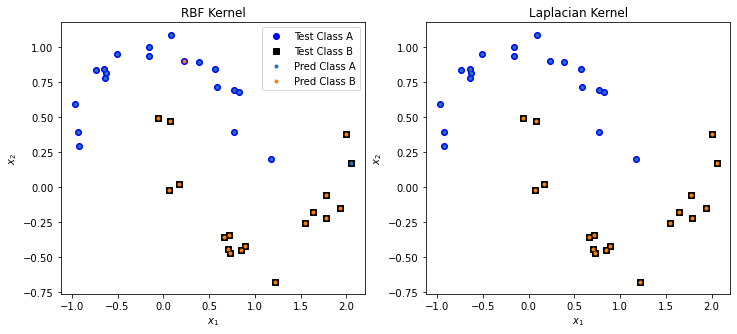

In [19]:
# Initialize fig and axes for plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
(ax1, ax2) = axs

# plot the results obtained using the RBF kernel
ax1.plot(test_x[test_y == 0, 0], test_x[test_y == 0, 1], 'o', color='blue')
ax1.plot(test_x[test_y == 1, 0], test_x[test_y == 1, 1], 's', color='black')
ax1.plot(test_x[rbf_observed_pred <= 0.5, 0], test_x[rbf_observed_pred <= 0.5, 1], '.')
ax1.plot(test_x[rbf_observed_pred >= 0.5, 0], test_x[rbf_observed_pred >= 0.5, 1], '.')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax1.legend(["Test Class A", "Test Class B", "Pred Class A", "Pred Class B"])
ax1.set_title("RBF Kernel")

# plot the results obtained using the Laplacian kernel
ax2.plot(test_x[test_y == 0, 0], test_x[test_y == 0, 1], 'o', color='blue')
ax2.plot(test_x[test_y == 1, 0], test_x[test_y == 1, 1], 's', color='black')
ax2.plot(test_x[laplacian_observed_pred <= 0.5, 0], test_x[laplacian_observed_pred <= 0.5, 1], '.')
ax2.plot(test_x[laplacian_observed_pred >= 0.5, 0], test_x[laplacian_observed_pred >= 0.5, 1], '.')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
# ax2.legend(["Test Class A", "Test Class B", "Pred Laplacian Class A", "Pred Laplacian Class B"])
ax2.set_title("Laplacian Kernel")

plt.show()

**TODO**
+ Also plot contours highlighting the decision boundary of the AGP
+ Improve the plot so it is more easy to read.